In [0]:
  !curl -s https://course.fast.ai/setup/colab | bash

Updating fastai...
Done.


In [0]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [0]:
!/opt/bin/nvidia-smi
!nvcc --version

Fri Mar 27 16:46:54 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 418.67       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   44C    P0    28W / 250W |      0MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

# Expirement 4 using ELA

In [0]:
import os
from fastai.vision import *
from fastai.metrics import error_rate

In [0]:
!wget 'https://fyp-content-bucket.s3.amazonaws.com/CASIA_ELA.zip.7z'

--2020-03-27 16:47:07--  https://fyp-content-bucket.s3.amazonaws.com/CASIA_ELA.zip.7z
Resolving fyp-content-bucket.s3.amazonaws.com (fyp-content-bucket.s3.amazonaws.com)... 52.216.110.203
Connecting to fyp-content-bucket.s3.amazonaws.com (fyp-content-bucket.s3.amazonaws.com)|52.216.110.203|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1375594296 (1.3G) [application/x-7z-compressed]
Saving to: ‘CASIA_ELA.zip.7z’

CASIA_ELA.zip.7z    100%[===================>]   1.28G  35.9MB/s    in 37s     

2020-03-27 16:47:45 (35.4 MB/s) - ‘CASIA_ELA.zip.7z’ saved [1375594296/1375594296]



In [0]:
!7z e CASIA_ELA.zip.7z


7-Zip [64] 16.02 : Copyright (c) 1999-2016 Igor Pavlov : 2016-05-21
p7zip Version 16.02 (locale=en_US.UTF-8,Utf16=on,HugeFiles=on,64 bits,2 CPUs Intel(R) Xeon(R) CPU @ 2.30GHz (306F0),ASM,AES-NI)

Scanning the drive for archives:
  0M Scan         1 file, 1375594296 bytes (1312 MiB)

Extracting archive: CASIA_ELA.zip.7z
--
Path = CASIA_ELA.zip.7z
Type = 7z
Physical Size = 1375594296
Headers Size = 130
Method = LZMA2:26
Solid = -
Blocks = 1

  0%      3% - CASIA_ELA.zip                      7% - CASIA_ELA.zip                     10% - CASIA_ELA.zip                     13% - CASIA_ELA.zip                     16% - CASIA_ELA.zip                     19% - CASIA_ELA.zip                     25% - CASIA_ELA.zip

In [0]:
!unzip -o -q CASIA_ELA.zip

In [0]:
path = Path("/root/.fastai/data/CASIA_ELA"); path

PosixPath('/root/.fastai/data/CASIA_ELA')

In [0]:
path_to_test = Path("/root/.fastai/data/CASIA_ELA/Test")
test = ImageList.from_folder(path_to_test)

In [0]:
data = ImageDataBunch.from_folder(path, train='Train', valid='Valid', 
                                  ds_tfms = get_transforms(do_flip=False), size=(256, 384), bs=64)

In [0]:
data.normalize(imagenet_stats)

ImageDataBunch;

Train: LabelList (7605 items)
x: ImageList
Image (3, 256, 384),Image (3, 256, 384),Image (3, 256, 384),Image (3, 256, 384),Image (3, 256, 384)
y: CategoryList
Tampered,Tampered,Tampered,Tampered,Tampered
Path: /root/.fastai/data/CASIA_ELA;

Valid: LabelList (4163 items)
x: ImageList
Image (3, 256, 384),Image (3, 256, 384),Image (3, 256, 384),Image (3, 256, 384),Image (3, 256, 384)
y: CategoryList
Tampered,Tampered,Tampered,Tampered,Tampered
Path: /root/.fastai/data/CASIA_ELA;

Test: None

In [0]:
data.add_test(test)

In [0]:
data.show_batch(rows=3, figsize=(12,12))

NameError: ignored

In [0]:
print(data.classes)
len(data.classes),data.c

['Authentic', 'Tampered']


(2, 2)

In [0]:
learn = cnn_learner(data, models.resnet50, metrics=error_rate)

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/checkpoints/resnet50-19c8e357.pth


epoch,train_loss,valid_loss,error_rate,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


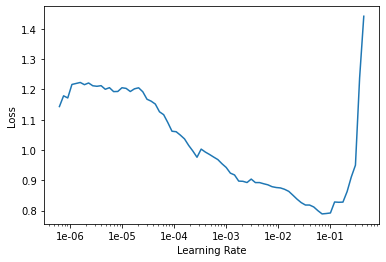

In [0]:
learn.lr_find()
learn.recorder.plot()

In [0]:
lr = 1e-02

In [0]:
learn.fit_one_cycle(20, lr)

epoch,train_loss,valid_loss,error_rate,time
0,0.390274,0.246886,0.096805,02:36
1,0.256834,0.236606,0.114100,02:33
2,0.219074,0.242305,0.105453,02:32
3,0.204140,0.221710,0.089599,02:32
4,0.196026,0.239896,0.101850,02:32
5,0.207444,0.241768,0.099448,02:31
6,0.184913,0.316059,0.087677,02:31
7,0.180850,0.206729,0.087437,02:30
8,0.161806,0.223395,0.087677,02:31
9,0.159378,0.173804,0.074706,02:32


In [0]:
learn.save('ela-exp2-attempt-1-resnet50')

epoch,train_loss,valid_loss,error_rate,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


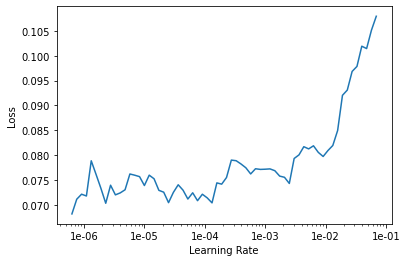

In [0]:
learn.lr_find()
learn.recorder.plot()

In [0]:
learn.unfreeze()
learn.fit_one_cycle(15, slice(1e-5, lr/5))

epoch,train_loss,valid_loss,error_rate,time
0,0.083855,0.130308,0.052847,02:42
1,0.090448,0.167577,0.067499,02:38
2,0.099209,0.148144,0.061494,02:41
3,0.102445,0.175098,0.075907,02:45
4,0.102446,0.138799,0.058131,02:46
5,0.098136,0.131885,0.056450,02:43
6,0.096499,0.128784,0.055729,02:42
7,0.098426,0.124024,0.053087,02:43
8,0.082758,0.136456,0.050204,02:43
9,0.081080,0.132589,0.054528,02:46


In [0]:
learn.save('ela-exp2-attempt-2-resnet50')

In [0]:
learn.export()

In [0]:
interp = ClassificationInterpretation.from_learner(learn)

In [0]:
interp.most_confused(min_val=2)

[('Tampered', 'Authentic', 111), ('Authentic', 'Tampered', 102)]

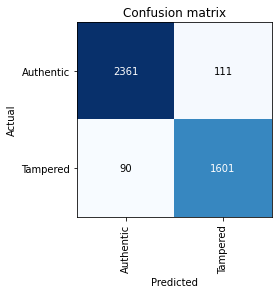

In [0]:
interp.plot_confusion_matrix()

In [0]:
learn = load_learner(path)

In [0]:
path = '/content/data/CASIA_ELA/Test/'
folders = os.listdir(path)

count_fake = 0
count_real = 0

conf_list = []

for folder in folders:
    if os.path.isdir(path + folder):
        new_path = os.path.join(path + folder + '/')
        print(new_path)
        for f in os.listdir(new_path):
            img = open_image(new_path + f)
            pred_class,pred_idx,confidence = learn.predict(img)
            if str(pred_class) == 'Tampered':
                if 'Tampered' == folder:
                    count_fake += 1
                conf = float(confidence[1])
            elif str(pred_class) == 'Authentic':
                if 'Authentic' == folder:
                    count_real += 1
                conf = float(confidence[0])
            conf = conf * 100
            
            conf_list.append(conf)
    
            print('Predicted: {} ------ Confidence: {:.3f}% ------ Actual: {}'.format(pred_class, conf, folder))
            
            

In [0]:
total_fake = len(os.listdir(str(path) + '/Tampered/'))
total_real = len(os.listdir(str(path) + '/Authentic/'))

In [0]:
accuracy_fake = (count_fake/total_fake) * 100
accuracy_real = (count_real/total_real) * 100

print('Images Classified As Authentic')
print('{}/{}. Accuracy = {:.2f}%'.format(count_real, total_real, accuracy_real))

print('Images Classified As Tampered')
print('{}/{}. Accuracy = {:.2f}%'.format(count_fake, total_fake, accuracy_fake))

Images Classified As Authentic
470/502. Accuracy = 93.63%
Images Classified As Tampered
321/344. Accuracy = 93.31%


In [0]:
average_conf = sum(conf_list) / len(conf_list)

print('Average confidence of the model = {:.3f}%'.format(average_conf))

Average confidence of the model = 97.309%
